In [2]:
import tensorflow as tf

# Clear any existing GPU settings
tf.keras.backend.clear_session()

# Set TensorFlow to run on GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Allow memory growth to prevent OOM (Out-of-Memory) errors
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("GPU is set up successfully!")
    except RuntimeError as e:
        print(f"GPU Setup Error: {e}")

GPU is set up successfully!


In [4]:
import tensorflow as tf
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from pathlib import Path
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from imblearn.over_sampling import ADASYN
from collections import Counter
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
from PIL import Image
import shutil

In [5]:
# Define dataset paths
dataset1_path = "/kaggle/input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/lung_image_sets"
dataset2_path = "/kaggle/input/iqothnccd-lung-cancer-dataset/The IQ-OTHNCCD lung cancer dataset/The IQ-OTHNCCD lung cancer dataset"

# Define target combined dataset path
combined_dataset_path = "/kaggle/working/Combined_Lung_Dataset"

# Mapping of original dataset folders to new 3-class structure
datasets = {
    "lung_n": "Normal",
    "Normal cases": "Normal",
    "Bengin cases": "Benign",
    "lung_aca": "Malignant",
    "lung_scc": "Malignant",
    "Malignant cases": "Malignant",
}

# Ensure target directories exist
for category in set(datasets.values()):
    os.makedirs(os.path.join(combined_dataset_path, category), exist_ok=True)

# Function to copy images while excluding text files
def copy_images(source_folder, target_folder):
    if os.path.exists(source_folder):
        for file in os.listdir(source_folder):
            if file.endswith((".jpg", ".png", ".jpeg")):  # Copy only image files
                shutil.copy(os.path.join(source_folder, file), os.path.join(target_folder, file))

# Copy files from dataset 1
for folder, category in datasets.items():
    source_folder = os.path.join(dataset1_path, folder)
    target_folder = os.path.join(combined_dataset_path, category)
    copy_images(source_folder, target_folder)

# Copy files from dataset 2
for folder, category in datasets.items():
    source_folder = os.path.join(dataset2_path, folder)
    target_folder = os.path.join(combined_dataset_path, category)
    copy_images(source_folder, target_folder)

# Remove empty folders
for category in set(datasets.values()):
    target_folder = os.path.join(combined_dataset_path, category)
    if len(os.listdir(target_folder)) == 0:  # If the folder is empty
        print(f"Removing empty folder: {target_folder}")
        shutil.rmtree(target_folder)

print("Dataset successfully merged into 3 classes: Normal, Benign, Malignant!")


Dataset successfully merged into 3 classes: Normal, Benign, Malignant!


In [6]:
# Define the path to the merged dataset
combined_dataset_path = "/kaggle/working/Combined_Lung_Dataset"

# Initialize a dictionary to store class-wise image count
class_counts = {}

# Loop through each class folder and count images
for class_name in os.listdir(combined_dataset_path):
    class_folder = os.path.join(combined_dataset_path, class_name)
    if os.path.isdir(class_folder):  # Ensure it's a folder
        num_images = len([file for file in os.listdir(class_folder) if file.endswith((".jpg", ".png", ".jpeg"))])
        class_counts[class_name] = num_images

# Display the result
for class_name, count in class_counts.items():
    print(f"{class_name}: {count} images")

# Total images across all classes
total_images = sum(class_counts.values())
print(f"\nTotal Images: {total_images}")


Malignant: 10561 images
Normal: 5416 images
Benign: 120 images

Total Images: 16097


**GAN Operation**

In [7]:
# === IMPORTS ===
import os
import shutil
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.utils import save_image
from torch.utils.data import DataLoader
from PIL import Image
import zipfile
import random
import numpy as np
from torch.autograd import grad
import torch.nn.functional as F
from IPython.display import FileLink

# === CONFIG ===
combined_dataset_path = "/kaggle/working/Combined_Lung_Dataset"
benign_dir = os.path.join(combined_dataset_path, "Benign")
dummy_class_dir = os.path.join(benign_dir, "DummyClass")
image_size = 256
batch_size = 32
latent_dim = 100
epochs = 1400
lr = 1e-4
n_critic = 5
lambda_gp = 10

checkpoint_dir = "/kaggle/working/checkpoints_benign_gan"
sample_dir = "/kaggle/working/generated_benign"
os.makedirs(checkpoint_dir, exist_ok=True)
os.makedirs(sample_dir, exist_ok=True)

output_dir = "/kaggle/working/Synthetic_Benign_Images"
os.makedirs(output_dir, exist_ok=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# === FIX FOLDER STRUCTURE ===
if not os.path.exists(dummy_class_dir):
    os.makedirs(dummy_class_dir)
    for file in os.listdir(benign_dir):
        file_path = os.path.join(benign_dir, file)
        if os.path.isfile(file_path) and file.lower().endswith(('.jpg', '.jpeg', '.png')):
            shutil.move(file_path, os.path.join(dummy_class_dir, file))

# === TRANSFORMS ===
transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

# === DATASET ===
dataset = datasets.ImageFolder(root=benign_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2)

# === GENERATOR ===
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, 1024, 4, 1, 0),   # 4x4
            nn.BatchNorm2d(1024), nn.ReLU(True),
            nn.ConvTranspose2d(1024, 512, 4, 2, 1),          # 8x8
            nn.BatchNorm2d(512), nn.ReLU(True),
            nn.ConvTranspose2d(512, 256, 4, 2, 1),           # 16x16
            nn.BatchNorm2d(256), nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, 4, 2, 1),           # 32x32
            nn.BatchNorm2d(128), nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 4, 2, 1),            # 64x64
            nn.BatchNorm2d(64), nn.ReLU(True),
            nn.ConvTranspose2d(64, 32, 4, 2, 1),             # 128x128
            nn.BatchNorm2d(32), nn.ReLU(True),
            nn.ConvTranspose2d(32, 3, 4, 2, 1),              # 256x256
            nn.Tanh()
        )

    def forward(self, z):
        return self.model(z)

# === DISCRIMINATOR (CLEAN WITHOUT MINIBATCH DISCRIMINATION) ===
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, 2, 1),
            nn.InstanceNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, 2, 1),
            nn.InstanceNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, 4, 2, 1),
            nn.InstanceNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True)
        )

        dummy = torch.zeros(1, 3, image_size, image_size)
        with torch.no_grad():
            out = self.features(dummy)
        self.flat_features = out.view(1, -1).shape[1]
        print("[DEBUG] flat_features computed for final layer:", self.flat_features)

        self.final = nn.Linear(self.flat_features, 1)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        return self.final(x)
# === GRADIENT PENALTY ===
def compute_gradient_penalty(D, real_samples, fake_samples):
    alpha = torch.rand(real_samples.size(0), 1, 1, 1, device=device)
    interpolates = (alpha * real_samples + ((1 - alpha) * fake_samples)).requires_grad_(True)
    d_interpolates = D(interpolates)
    fake = torch.ones_like(d_interpolates, requires_grad=False)
    gradients = grad(outputs=d_interpolates, inputs=interpolates,
                     grad_outputs=fake, create_graph=True, retain_graph=True, only_inputs=True)[0]
    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty

# === INIT MODELS ===
netG = Generator().to(device)
netD = Discriminator().to(device)
optimizer_G = optim.Adam(netG.parameters(), lr=lr, betas=(0.5, 0.9))
optimizer_D = optim.Adam(netD.parameters(), lr=lr, betas=(0.5, 0.9))

fixed_noise = torch.randn(64, latent_dim, 1, 1, device=device)

# === TRAINING LOOP ===
for epoch in range(epochs):
    for i, (imgs, _) in enumerate(dataloader):
        real_imgs = imgs.to(device)
        batch_size = real_imgs.size(0)

        for _ in range(n_critic):
            z = torch.randn(batch_size, latent_dim, 1, 1, device=device)
            fake_imgs = netG(z).detach()

            real_validity = netD(real_imgs)
            fake_validity = netD(fake_imgs)
            gp = compute_gradient_penalty(netD, real_imgs, fake_imgs)
            d_loss = -torch.mean(real_validity) + torch.mean(fake_validity) + lambda_gp * gp

            optimizer_D.zero_grad()
            d_loss.backward()
            optimizer_D.step()

        z = torch.randn(batch_size, latent_dim, 1, 1, device=device)
        gen_imgs = netG(z)
        g_loss = -torch.mean(netD(gen_imgs))

        optimizer_G.zero_grad()
        g_loss.backward()
        optimizer_G.step()

        if i % 10 == 0:
            print(f"[Epoch {epoch}/{epochs}] [Batch {i}/{len(dataloader)}] Loss_D: {d_loss.item():.4f}, Loss_G: {g_loss.item():.4f}")

    save_image(netG(fixed_noise).detach().cpu(), os.path.join(sample_dir, f"epoch_{epoch}.png"), normalize=True)

    torch.save({
        'epoch': epoch,
        'netG': netG.state_dict(),
        'netD': netD.state_dict(),
        'optimizerG': optimizer_G.state_dict(),
        'optimizerD': optimizer_D.state_dict(),
    }, os.path.join(checkpoint_dir, 'checkpoint.pth'))

    print(f"\u2705 Checkpoint saved at epoch {epoch}")

# === GENERATE FINAL SYNTHETIC IMAGES ===
netG.eval()
num_generate = 5000
for i in range(num_generate):
    z = torch.randn(1, latent_dim, 1, 1, device=device)
    with torch.no_grad():
        img = netG(z).detach().cpu()
    save_image(img, os.path.join(output_dir, f"benign_{i:04d}.png"), normalize=True)

print(f"\u2705 {num_generate} synthetic benign images saved to {output_dir}")

# === ZIP CHECKPOINTS ===
output_zip = "/kaggle/working/checkpoints_benign_gan.zip"
with zipfile.ZipFile(output_zip, "w") as zipf:
    for root, _, files in os.walk(checkpoint_dir):
        for file in files:
            file_path = os.path.join(root, file)
            arcname = os.path.relpath(file_path, checkpoint_dir)
            zipf.write(file_path, arcname)

print("\ud83d\udce6 Checkpoint zipped at: /kaggle/working/checkpoints_benign_gan.zip")
# Define the folder and zip paths
folder_path = "/kaggle/working/Synthetic_Benign_Images"
zip_path = "/kaggle/working/Synthetic_Benign_Images.zip"

# Create a zip file of the folder
shutil.make_archive(base_name=zip_path.replace('.zip', ''), format='zip', root_dir=folder_path)

# Move the zip file to the output folder (in Kaggle environment, the output folder is /kaggle/working/)
output_folder_path = '/kaggle/working/'  # Default output directory for Kaggle notebooks
shutil.move(zip_path, os.path.join(output_folder_path, 'Synthetic_Benign_Images.zip'))

print(f"✅ Folder zipped and moved to output folder: {os.path.join(output_folder_path, 'Synthetic_Benign_Images.zip')}")

[DEBUG] flat_features computed for final layer: 131072
[Epoch 0/1400] [Batch 0/4] Loss_D: -24.5774, Loss_G: 15.3574
✅ Checkpoint saved at epoch 0
[Epoch 1/1400] [Batch 0/4] Loss_D: -185.7120, Loss_G: 101.1060
✅ Checkpoint saved at epoch 1
[Epoch 2/1400] [Batch 0/4] Loss_D: -363.3738, Loss_G: 204.5741
✅ Checkpoint saved at epoch 2
[Epoch 3/1400] [Batch 0/4] Loss_D: -519.0466, Loss_G: 308.5326
✅ Checkpoint saved at epoch 3
[Epoch 4/1400] [Batch 0/4] Loss_D: -685.3422, Loss_G: 410.1288
✅ Checkpoint saved at epoch 4
[Epoch 5/1400] [Batch 0/4] Loss_D: -696.2874, Loss_G: 453.8963
✅ Checkpoint saved at epoch 5
[Epoch 6/1400] [Batch 0/4] Loss_D: -691.9861, Loss_G: 520.1312
✅ Checkpoint saved at epoch 6
[Epoch 7/1400] [Batch 0/4] Loss_D: -694.9405, Loss_G: 567.6763
✅ Checkpoint saved at epoch 7
[Epoch 8/1400] [Batch 0/4] Loss_D: -636.5364, Loss_G: 544.3768
✅ Checkpoint saved at epoch 8
[Epoch 9/1400] [Batch 0/4] Loss_D: -559.1407, Loss_G: 531.9486
✅ Checkpoint saved at epoch 9
[Epoch 10/1400] [

In [8]:
import os

# Check if the zip file exists
zip_path = "/kaggle/working/Synthetic_Benign_Images.zip"
print(f"Does the file exist? {os.path.exists(zip_path)}")


Does the file exist? True


In [ ]:
# Checking if the folder exists
os.path.exists('/kaggle/working/Synthetic_Benign_Images')


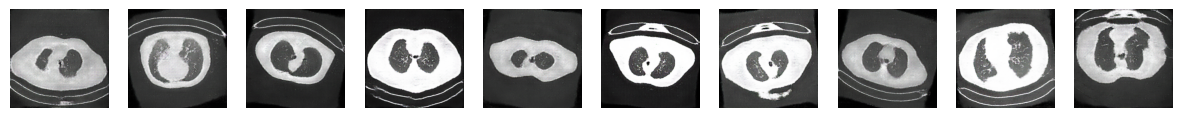

In [10]:
import os
import random
from PIL import Image
import matplotlib.pyplot as plt

# Set the directory path
folder_path = "/kaggle/working/Synthetic_Benign_Images"

# Get a list of all image files in the directory
image_files = [f for f in os.listdir(folder_path) if f.endswith('.png')]

# Randomly select a few images to display
sample_images = random.sample(image_files, 10)  # You can change the number to display more/less

# Set up the plot
fig, axes = plt.subplots(1, len(sample_images), figsize=(15, 5))

# Display each selected image
for ax, img_file in zip(axes, sample_images):
    img_path = os.path.join(folder_path, img_file)
    img = Image.open(img_path)
    ax.imshow(img)
    ax.axis('off')  # Hide axis

plt.show()


In [11]:
# === Paths ===
real_benign = "/kaggle/working/Combined_Lung_Dataset/Benign/DummyClass"
synthetic_benign = "/kaggle/working/Synthetic_Benign_Images"
target_non_malignant = "/kaggle/working/Combined_Lung_Dataset/Non-Malignant"

# Create target folder
os.makedirs(target_non_malignant, exist_ok=True)

# === Copy Real Benign Images ===
for filename in os.listdir(real_benign):
    if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
        src = os.path.join(real_benign, filename)
        dst = os.path.join(target_non_malignant, f"real_{filename}")
        shutil.copyfile(src, dst)

# === Copy Synthetic Benign Images ===
for filename in os.listdir(synthetic_benign):
    if filename.lower().endswith('.png'):  # All synthetic are .png
        src = os.path.join(synthetic_benign, filename)
        dst = os.path.join(target_non_malignant, f"synthetic_{filename}")
        shutil.copyfile(src, dst)

print(f"✅ Combined Real + Synthetic Benign images into: {target_non_malignant}")
print(f"🧾 Total: {len(os.listdir(target_non_malignant))} images")


✅ Combined Real + Synthetic Benign images into: /kaggle/working/Combined_Lung_Dataset/Non-Malignant
🧾 Total: 5120 images


In [12]:
# === Define paths ===
root_dataset = "/kaggle/working/Combined_Lung_Dataset"
normal_dir = os.path.join(root_dataset, "Normal")
benign_combined_dir = os.path.join(root_dataset, "Non-Malignant")  # this contains real + synthetic Benign
malignant_dir = os.path.join(root_dataset, "Malignant")

# Final binary class folder
final_dataset = "/kaggle/working/Final_Binary_Dataset"
final_non_malignant = os.path.join(final_dataset, "Non-Malignant")
final_malignant = os.path.join(final_dataset, "Malignant")

# === Create directories ===
os.makedirs(final_non_malignant, exist_ok=True)
os.makedirs(final_malignant, exist_ok=True)

# === Copy Normal images to Non-Malignant ===
for file in os.listdir(normal_dir):
    if file.lower().endswith(('.png', '.jpg', '.jpeg')):
        src = os.path.join(normal_dir, file)
        dst = os.path.join(final_non_malignant, f"normal_{file}")
        shutil.copyfile(src, dst)

# === Copy Benign (real + synthetic) to Non-Malignant ===
for file in os.listdir(benign_combined_dir):
    if file.lower().endswith('.png') or file.lower().endswith(('.jpg', '.jpeg')):
        src = os.path.join(benign_combined_dir, file)
        dst = os.path.join(final_non_malignant, file)
        shutil.copyfile(src, dst)

# === Copy Malignant images ===
for file in os.listdir(malignant_dir):
    if file.lower().endswith(('.png', '.jpg', '.jpeg')):
        src = os.path.join(malignant_dir, file)
        dst = os.path.join(final_malignant, file)
        shutil.copyfile(src, dst)

print("✅ Final Binary Dataset structure created at /kaggle/working/Final_Binary_Dataset")
print(f"📁 Non-Malignant: {len(os.listdir(final_non_malignant))} images")
print(f"📁 Malignant: {len(os.listdir(final_malignant))} images")


✅ Final Binary Dataset structure created at /kaggle/working/Final_Binary_Dataset
📁 Non-Malignant: 10536 images
📁 Malignant: 10561 images


In [13]:
# Parameters
image_size = (224, 224)
data_dir = "/kaggle/working/Final_Binary_Dataset"
mean = tf.convert_to_tensor([0.485, 0.456, 0.406], dtype=tf.float32)
std = tf.convert_to_tensor([0.229, 0.224, 0.225], dtype=tf.float32)

In [14]:
import os
import numpy as np

image_paths = []
labels = []
label_dict = {}

for idx, class_name in enumerate(os.listdir(data_dir)):
    class_dir = os.path.join(data_dir, class_name)
    if os.path.isdir(class_dir):
        label_dict[class_name] = idx
        for file_name in os.listdir(class_dir):
            file_path = os.path.join(class_dir, file_name)
            image_paths.append(file_path)
            labels.append(idx)

image_paths = np.array(image_paths)
labels = np.array(labels)

print("✅ Loaded image paths and labels.")
print("🔢 Label Mapping:", label_dict)
print("📦 Total Images:", len(image_paths))


✅ Loaded image paths and labels.
🔢 Label Mapping: {'Non-Malignant': 0, 'Malignant': 1}
📦 Total Images: 21097


In [15]:
import os
import numpy as np
from sklearn.model_selection import train_test_split

data_dir = "/kaggle/working/Final_Binary_Dataset"
np.random.seed(42)

image_paths = []
labels = []
synthetic_paths = []
synthetic_labels = []
label_dict = {}

# === Load image paths and separate synthetic ===
for idx, class_name in enumerate(sorted(os.listdir(data_dir))):
    class_dir = os.path.join(data_dir, class_name)
    if os.path.isdir(class_dir):
        label_dict[class_name] = idx
        for file in os.listdir(class_dir):
            full_path = os.path.join(class_dir, file)
            if class_name == "Non-Malignant" and file.startswith("synthetic_"):
                synthetic_paths.append(full_path)
                synthetic_labels.append(idx)
            else:
                image_paths.append(full_path)
                labels.append(idx)

image_paths = np.array(image_paths)
labels = np.array(labels)
synthetic_paths = np.array(synthetic_paths)
synthetic_labels = np.array(synthetic_labels)

# === Split real data into 70% train, 20% val, 10% test ===
X_temp, X_test, y_temp, y_test = train_test_split(
    image_paths, labels, test_size=0.1, stratify=labels, random_state=42)

X_train_real, X_val, y_train_real, y_val = train_test_split(
    X_temp, y_temp, test_size=2/9, stratify=y_temp, random_state=42)  # 2/9 of 90% → ~20%

# === Add synthetic data to training set only ===
X_train = np.concatenate((X_train_real, synthetic_paths))
y_train = np.concatenate((y_train_real, synthetic_labels))

# === Done ===
print("✅ 70/20/10 Split complete (synthetic used only in training).")
print(f"📦 Training Set: {len(X_train)} images (with synthetic)")
print(f"🧪 Validation Set: {len(X_val)} images (real only)")
print(f"🧫 Test Set: {len(X_test)} images (real only)")


✅ 70/20/10 Split complete (synthetic used only in training).
📦 Training Set: 16267 images (with synthetic)
🧪 Validation Set: 3220 images (real only)
🧫 Test Set: 1610 images (real only)


In [17]:
import numpy as np
from collections import Counter

def print_distribution(y, name=""):
    counts = Counter(y)
    total = len(y)
    print(f"📊 {name} Set Distribution:")
    for label, count in sorted(counts.items()):
        percentage = (count / total) * 100
        print(f"  Class {label} → {count} samples ({percentage:.2f}%)")
    print(f"  Total: {total} images\n")

# Example:
print_distribution(y_train, "Train")
print_distribution(y_val, "Validation")
print_distribution(y_test, "Test")


📊 Train Set Distribution:
  Class 0 → 7392 samples (45.44%)
  Class 1 → 8875 samples (54.56%)
  Total: 16267 images

📊 Validation Set Distribution:
  Class 0 → 2113 samples (65.62%)
  Class 1 → 1107 samples (34.38%)
  Total: 3220 images

📊 Test Set Distribution:
  Class 0 → 1056 samples (65.59%)
  Class 1 → 554 samples (34.41%)
  Total: 1610 images



In [19]:
@tf.function
def augment_image(image, label):
    # Random Flip (Left-Right & Up-Down)
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)

    # Random Rotation (0°, 90°, 180°, 270°)
    k = tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32)
    image = tf.image.rot90(image, k=k)

    # Random Brightness and Contrast
    image = tf.image.random_brightness(image, max_delta=0.1)
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)

    # Random Saturation
    image = tf.image.random_saturation(image, lower=0.8, upper=1.2)
    image = tf.image.random_jpeg_quality(image, min_jpeg_quality=70, max_jpeg_quality=100)  # JPEG compression simulation

    # Add Gaussian Noise
    noise = tf.random.normal(shape=tf.shape(image), mean=0.0, stddev=0.01, dtype=tf.float32)
    image = tf.clip_by_value(image + noise, 0.0, 1.0)

    return image, label

In [20]:
# ================= Preprocessing Function ================= #
def load_and_preprocess_image(image_path, label, augment=False):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, image_size)
    print("Before normalization:", tf.reduce_min(img), tf.reduce_max(img))
    img = img / 255.0  # Normalize pixel values
    print("After division by 255:", tf.reduce_min(img), tf.reduce_max(img))
    # Apply augmentation only if augment=True
    if augment:
        img, label = augment_image(img, label)
    print("After mean/std normalization:", tf.reduce_min(img), tf.reduce_max(img))
    img = (img - mean) / std  # Apply mean-std normalization
    img = tf.cast(img, tf.float32)
    return img, label

In [21]:
# ================= Dataset Creation ================= #
def create_dataset(image_paths, labels, batch_size=4, shuffle=True, augment=False):
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))
    dataset = dataset.map(lambda x, y: load_and_preprocess_image(x, y, augment), num_parallel_calls=tf.data.AUTOTUNE)
    if shuffle:
        dataset = dataset.shuffle(len(image_paths))
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

In [22]:
# Create datasets
train_dataset = create_dataset(X_train, y_train, augment=True)  # Augmentation only in training
val_dataset = create_dataset(X_val, y_val, shuffle=False)
test_dataset = create_dataset(X_test, y_test, shuffle=False)


Before normalization: Tensor("Min:0", shape=(), dtype=float32) Tensor("Max:0", shape=(), dtype=float32)
After division by 255: Tensor("Min_1:0", shape=(), dtype=float32) Tensor("Max_1:0", shape=(), dtype=float32)
After mean/std normalization: Tensor("Min_2:0", shape=(), dtype=float32) Tensor("Max_2:0", shape=(), dtype=float32)
Before normalization: Tensor("Min:0", shape=(), dtype=float32) Tensor("Max:0", shape=(), dtype=float32)
After division by 255: Tensor("Min_1:0", shape=(), dtype=float32) Tensor("Max_1:0", shape=(), dtype=float32)
After mean/std normalization: Tensor("Min_2:0", shape=(), dtype=float32) Tensor("Max_2:0", shape=(), dtype=float32)
Before normalization: Tensor("Min:0", shape=(), dtype=float32) Tensor("Max:0", shape=(), dtype=float32)
After division by 255: Tensor("Min_1:0", shape=(), dtype=float32) Tensor("Max_1:0", shape=(), dtype=float32)
After mean/std normalization: Tensor("Min_2:0", shape=(), dtype=float32) Tensor("Max_2:0", shape=(), dtype=float32)


In [23]:
for batch_images, batch_labels in train_dataset.take(1):
    mean_val = tf.reduce_mean(batch_images).numpy()
    max_val = tf.reduce_max(batch_images).numpy()
    min_val = tf.reduce_min(batch_images).numpy()
    print(f"📊 Batch Mean: {mean_val:.4f}")
    print(f"📈 Batch Max: {max_val:.4f}")
    print(f"📉 Batch Min: {min_val:.4f}")


📊 Batch Mean: 0.9027
📈 Batch Max: 2.6400
📉 Batch Min: -2.1179


In [24]:
for batch_images, batch_labels in val_dataset.take(1):
    mean_val = tf.reduce_mean(batch_images).numpy()
    max_val = tf.reduce_max(batch_images).numpy()
    min_val = tf.reduce_min(batch_images).numpy()
    print(f"📊 Batch Mean: {mean_val:.4f}")
    print(f"📈 Batch Max: {max_val:.4f}")
    print(f"📉 Batch Min: {min_val:.4f}")

📊 Batch Mean: 0.9233
📈 Batch Max: 2.6400
📉 Batch Min: -2.0357


In [25]:
for batch_images, batch_labels in test_dataset.take(1):
    mean_val = tf.reduce_mean(batch_images).numpy()
    max_val = tf.reduce_max(batch_images).numpy()
    min_val = tf.reduce_min(batch_images).numpy()
    print(f"📊 Batch Mean: {mean_val:.4f}")
    print(f"📈 Batch Max: {max_val:.4f}")
    print(f"📉 Batch Min: {min_val:.4f}")

📊 Batch Mean: 1.1092
📈 Batch Max: 2.6400
📉 Batch Min: -2.1179


In [28]:
import matplotlib.pyplot as plt

def show_batch(dataset, title="Sample Images"):
    for images, labels in dataset.take(1):
        images = (images + 1) / 2.0  # Denormalize from [-1, 1] → [0, 1]
        plt.figure(figsize=(15, 6))
        for i in range(min(10, images.shape[0])):
            ax = plt.subplot(2, 5, i + 1)  # 2 rows, 5 columns
            plt.imshow(images[i].numpy())
            plt.title(f"Label: {labels[i].numpy()}")
            plt.axis("off")
        plt.suptitle(title, fontsize=16)
        plt.tight_layout()
        plt.show()

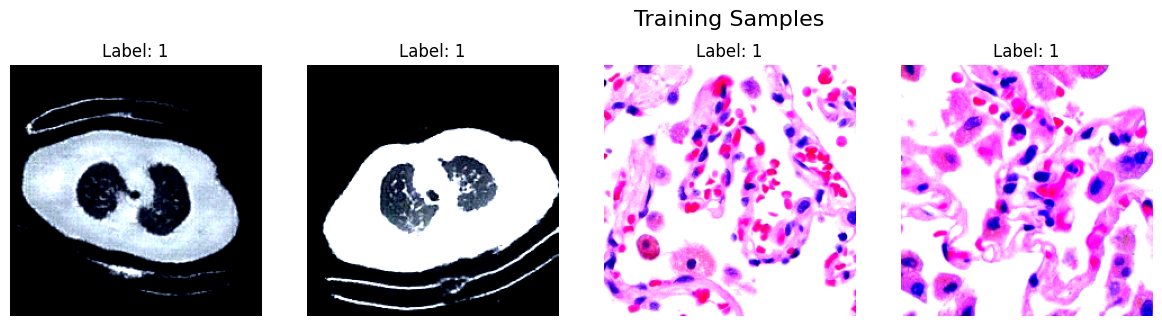

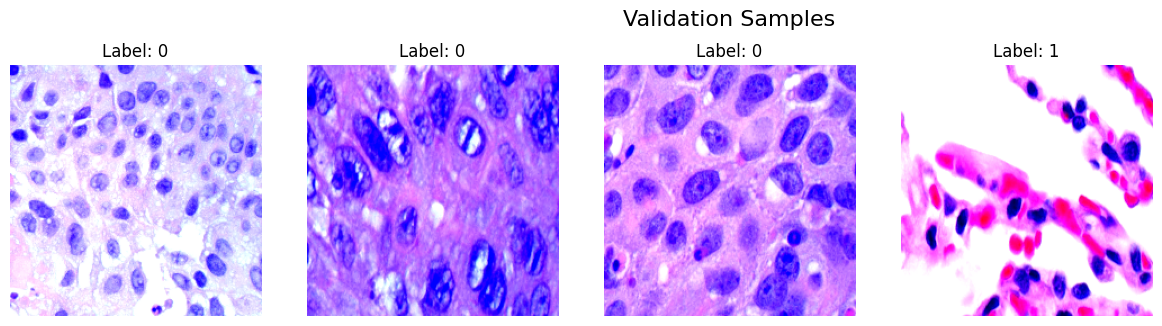

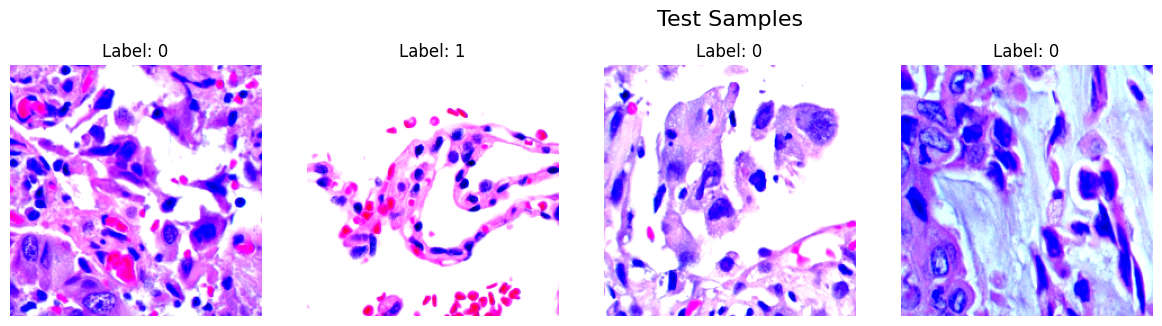

In [29]:
show_batch(train_dataset, title="Training Samples")
show_batch(val_dataset, title="Validation Samples")
show_batch(test_dataset, title="Test Samples")
